In [1]:
%load_ext autoreload
%autoreload 2
import sys

In [2]:
sys.path.insert(0, "../")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F

In [4]:

class Classifier(nn.Module): 
    def __init__(self, classes: int = 10): 
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        #self.dropout1 = nn.Dropout2d(0.25) 
        #self.dropout2 = nn.Dropout2d(0.5) 
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, classes) 
  
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) 
        #x = self.dropout1(x) 
        x = self.pool(F.relu(self.conv2(x))) 
        #x = self.dropout2(x) 
        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        return x

In [5]:
# imports for model changes
from src.methods.bayes.variational.net import VarBayesModuleNet, LogUniformVarBayesModule
from src.methods.bayes.variational.optimization import LogUniformVarKLLoss

In [6]:
# imports for trainer
from src.methods.bayes.variational.trainer import VarBayesTrainer, VarTrainerParams, Beta_Scheduler_Plato, CallbackLossAccuracy
from src.methods.report.base import ReportChain
from src.methods.report.variational import VarBaseReport

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

### Define parameters for training

In [9]:
EPOCHS=5

BATCH_SIZE=1024
LR = 1e-3 #5e-4
# Split the training set into training and validation sets 
VAL_PERCENT = 0.2 # percentage of the data used for validation 
SAMPLES = 10
BETA = 1e-2 #5e-5 #len(train_dataset) *1. / BATCH_SIZE
BETA_FAC = 5e-1
PRUNE = -5#1.99, 2.1
PLATO_TOL = 20

# define a module and make a Bayesian model out of it
"""
base_module = Classifier()
var_module = LogUniformVarBayesModule(base_module)
model = VarBayesModuleNet(base_module, nn.ModuleList([var_module]))
"""
base_module = Classifier()
var_module1 = LogUniformVarBayesModule(base_module.conv1)
#bayes_model = VarBayesModuleNet(module, nn.ModuleList([var_module])) #Первый аргумент базовая сеть, второй список всех слоев (где нужные из них являются байесовыми)
model = VarBayesModuleNet(base_module, nn.ModuleDict({'conv1': var_module1}))

# set an optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# define losses
fit_loss = nn.CrossEntropyLoss() 
kl_loss = LogUniformVarKLLoss()

# define loss scalers scheduler
beta = Beta_Scheduler_Plato(BETA, BETA_FAC, PLATO_TOL)
beta_KL = Beta_Scheduler_Plato(beta.beta, 1 / BETA_FAC, PLATO_TOL, ref = beta, threshold=1e-4)


def post_train_step(trainer: VarTrainerParams, train_result: VarBayesTrainer.TrainResult):
    beta.step(train_result.fit_loss)
    beta_KL.step(train_result.dist_loss)
    trainer.params.beta = float(beta)

train_params = VarTrainerParams(
                num_epochs= EPOCHS, 
                optimizer=optimizer, 
                fit_loss=fit_loss, 
                dist_loss= kl_loss,
                num_samples=SAMPLES,
                prune_threshold=PRUNE,
                beta=beta,
                callback_losses={'accuracy': CallbackLossAccuracy()}
                )

### prepare dataloader

In [10]:
val_size    = int(VAL_PERCENT * len(train_dataset)) 
train_size  = len(train_dataset) - val_size 

t_dataset, v_dataset = torch.utils.data.random_split(train_dataset,  
                                                        [train_size,  
                                                            val_size]) 

# Create DataLoaders for the training and validation sets 
train_loader = torch.utils.data.DataLoader(t_dataset,  
                                        batch_size=BATCH_SIZE,  
                                        shuffle=True, 
                                        pin_memory=True) 

eval_loader = torch.utils.data.DataLoader(v_dataset,  
                                        batch_size=BATCH_SIZE,  
                                        shuffle=False, 
                                        pin_memory=True)

### train model

In [11]:
model.to(device)

# if one wanna to use fixed betas, then use second line
trainer = VarBayesTrainer(train_params, ReportChain([VarBaseReport()]), train_loader, eval_loader, [post_train_step])
# trainer = VarBayesTrainer(train_params, ReportChain([VarBaseReport()]), train_loader, eval_loader)

trainer.train(model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5],Loss:25.343673706054688, KL Loss: 2327.2314453125. FitLoss: 2.0713610649108887,Accuracy:0.41454045222355773,Validation Loss:24.8254451751709,Validation Accuracy:0.6997950819672131, Prune parameters: 0.0/320,Beta: 0.01
Epoch [2/5],Loss:24.374618530273438, KL Loss: 2323.19482421875. FitLoss: 1.1426671743392944,Accuracy:0.7385178786057691,Validation Loss:23.92967987060547,Validation Accuracy:0.7889344262295082, Prune parameters: 0.0/320,Beta: 0.01
Epoch [3/5],Loss:23.797780990600586, KL Loss: 2319.248779296875. FitLoss: 0.6052942872047424,Accuracy:0.808795635516827,Validation Loss:23.672582626342773,Validation Accuracy:0.8432377049180327, Prune parameters: 0.0/320,Beta: 0.01
Epoch [4/5],Loss:23.60993766784668, KL Loss: 2315.275146484375. FitLoss: 0.4571865200996399,Accuracy:0.8576040414663462,Validation Loss:23.557052612304688,Validation Accuracy:0.8790983606557377, Prune parameters: 0.0/320,Beta: 0.01
Epoch [5/5],Loss:23.494670867919922, KL Loss: 2311.255126953125. FitLoss: 0

### Show, that  trained model can be pruned well

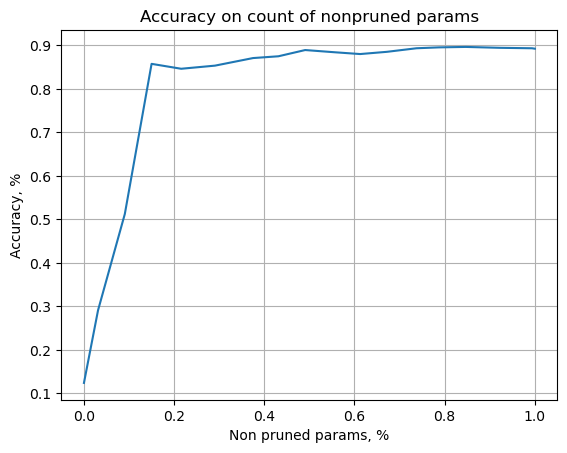

In [12]:
thresholds = np.linspace(1, 4, 25)
threshold_results = trainer.eval_thresholds(model, thresholds)

# plot dependence of accuracy on count on non pruned parameter
x_s = [(a.cnt_prune_parameters / a.cnt_params).cpu().numpy() for a in threshold_results]
x_s = 1. - np.array(x_s) # now we get partition of non pruned parameters
y_s = [a.custom_losses["val_accuracy"] for a in threshold_results]

plt.plot(x_s, y_s)
plt.xlabel("Non pruned params, %")
plt.ylabel("Accuracy, %")
plt.title("Accuracy on count of nonpruned params")
plt.grid()